In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
library(tidyverse)
library(foreach)
library(parallel)
library(data.table)
library(lubridate)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose



Attaching package: ‘lubridate’


The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




Input the full_nonrookie contract data

In [3]:
contracts = fread('../input/st540-project/data/full_nonrookie.csv')
head(contracts)

fullName,term,signAge,contractLength,totalValue,aav,isEntryLevel,signSeason,Tm,G,⋯,DBPM_prev2,BPM_prev2,VORP_prev2,height,weight,birthDate,draftRound,draftOverall,draftYear,undrafted
<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<int>,<chr>,<chr>,<int>,⋯,<dbl>,<dbl>,<dbl>,<int>,<int>,<date>,<int>,<int>,<int>,<lgl>
Carmelo Anthony,2014-2018,30,5,124064681,24812936,0,2013-14,NYK,77,⋯,-0.2,3.6,2.7,79,238,1984-05-29,1,3,2003,FALSE
Carmelo Anthony,2018-2018,34,1,2393887,2393887,0,2017-18,OKC,78,⋯,-0.5,3.3,3.4,79,238,1984-05-29,1,3,2003,FALSE
Carmelo Anthony,2020-2020,36,1,2564753,2564753,0,2019-20,POR,58,⋯,-1.3,-1.9,0.0,79,238,1984-05-29,1,3,2003,FALSE
Carmelo Anthony,2021-2021,37,1,2641691,2641691,0,2020-21,POR,69,⋯,-1.4,-2.7,-0.1,79,238,1984-05-29,1,3,2003,FALSE
Chris Bosh,2014-2018,29,5,118705300,23741060,0,2013-14,MIA,79,⋯,-0.2,0.8,1.4,83,235,1984-03-24,1,4,2003,FALSE
Paul George,2014-2018,23,5,91572660,18314532,0,2013-14,IND,80,⋯,2.1,3.4,2.7,80,220,1990-05-02,1,10,2010,FALSE


In [4]:
summary(contracts)

   fullName             term              signAge      contractLength 
 Length:1412        Length:1412        Min.   : 0.00   Min.   :1.000  
 Class :character   Class :character   1st Qu.:24.00   1st Qu.:1.000  
 Mode  :character   Mode  :character   Median :27.00   Median :1.000  
                                       Mean   :27.51   Mean   :1.935  
                                       3rd Qu.:30.00   3rd Qu.:3.000  
                                       Max.   :42.00   Max.   :5.000  
   totalValue             aav            isEntryLevel  signSeason       
 Min.   :     9127   Min.   :    9127   Min.   :0     Length:1412       
 1st Qu.:  1551659   1st Qu.: 1445697   1st Qu.:0     Class :character  
 Median :  2899748   Median : 2320044   Median :0     Mode  :character  
 Mean   : 18494276   Mean   : 6044562   Mean   :0                       
 3rd Qu.: 17783043   3rd Qu.: 7397006   3rd Qu.:0                       
 Max.   :228200420   Max.   :45640084   Max.   :0                

Removing IsEntryLevel since it is not a column with more than 1 unique value. Birthdate will be transformed into a proper date object. Term will be split into a start year and end year (while keeping original column). A year signed using the last year of sign season will be used.

In [5]:
contracts$isEntryLevel = NULL
contracts[,birthDate:=ymd(birthDate)]

In [6]:
head(contracts)

fullName,term,signAge,contractLength,totalValue,aav,signSeason,Tm,G,GS,⋯,DBPM_prev2,BPM_prev2,VORP_prev2,height,weight,birthDate,draftRound,draftOverall,draftYear,undrafted
<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<int>,<int>,<date>,<int>,<int>,<int>,<lgl>
Carmelo Anthony,2014-2018,30,5,124064681,24812936,2013-14,NYK,77,77,⋯,-0.2,3.6,2.7,79,238,1984-05-29,1,3,2003,FALSE
Carmelo Anthony,2018-2018,34,1,2393887,2393887,2017-18,OKC,78,78,⋯,-0.5,3.3,3.4,79,238,1984-05-29,1,3,2003,FALSE
Carmelo Anthony,2020-2020,36,1,2564753,2564753,2019-20,POR,58,58,⋯,-1.3,-1.9,0.0,79,238,1984-05-29,1,3,2003,FALSE
Carmelo Anthony,2021-2021,37,1,2641691,2641691,2020-21,POR,69,3,⋯,-1.4,-2.7,-0.1,79,238,1984-05-29,1,3,2003,FALSE
Chris Bosh,2014-2018,29,5,118705300,23741060,2013-14,MIA,79,79,⋯,-0.2,0.8,1.4,83,235,1984-03-24,1,4,2003,FALSE
Paul George,2014-2018,23,5,91572660,18314532,2013-14,IND,80,80,⋯,2.1,3.4,2.7,80,220,1990-05-02,1,10,2010,FALSE


In [7]:
contracts[,`:=`(termFirstYear = as.numeric(str_extract(term, '\\d{3,}(?=-)')),
               termSecondYear = as.numeric(str_extract(term, '(?<=-)\\d{3,}')))]
head(contracts)

fullName,term,signAge,contractLength,totalValue,aav,signSeason,Tm,G,GS,⋯,VORP_prev2,height,weight,birthDate,draftRound,draftOverall,draftYear,undrafted,termFirstYear,termSecondYear
<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,⋯,<dbl>,<int>,<int>,<date>,<int>,<int>,<int>,<lgl>,<dbl>,<dbl>
Carmelo Anthony,2014-2018,30,5,124064681,24812936,2013-14,NYK,77,77,⋯,2.7,79,238,1984-05-29,1,3,2003,FALSE,2014,2018
Carmelo Anthony,2018-2018,34,1,2393887,2393887,2017-18,OKC,78,78,⋯,3.4,79,238,1984-05-29,1,3,2003,FALSE,2018,2018
Carmelo Anthony,2020-2020,36,1,2564753,2564753,2019-20,POR,58,58,⋯,0.0,79,238,1984-05-29,1,3,2003,FALSE,2020,2020
Carmelo Anthony,2021-2021,37,1,2641691,2641691,2020-21,POR,69,3,⋯,-0.1,79,238,1984-05-29,1,3,2003,FALSE,2021,2021
Chris Bosh,2014-2018,29,5,118705300,23741060,2013-14,MIA,79,79,⋯,1.4,83,235,1984-03-24,1,4,2003,FALSE,2014,2018
Paul George,2014-2018,23,5,91572660,18314532,2013-14,IND,80,80,⋯,2.7,80,220,1990-05-02,1,10,2010,FALSE,2014,2018


In [8]:
contracts[,signYear:=as.numeric(str_c('20',
                                      str_extract(signSeason, '(?<=-)\\d{2,}'), sep=''))]
head(contracts)

fullName,term,signAge,contractLength,totalValue,aav,signSeason,Tm,G,GS,⋯,height,weight,birthDate,draftRound,draftOverall,draftYear,undrafted,termFirstYear,termSecondYear,signYear
<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,⋯,<int>,<int>,<date>,<int>,<int>,<int>,<lgl>,<dbl>,<dbl>,<dbl>
Carmelo Anthony,2014-2018,30,5,124064681,24812936,2013-14,NYK,77,77,⋯,79,238,1984-05-29,1,3,2003,FALSE,2014,2018,2014
Carmelo Anthony,2018-2018,34,1,2393887,2393887,2017-18,OKC,78,78,⋯,79,238,1984-05-29,1,3,2003,FALSE,2018,2018,2018
Carmelo Anthony,2020-2020,36,1,2564753,2564753,2019-20,POR,58,58,⋯,79,238,1984-05-29,1,3,2003,FALSE,2020,2020,2020
Carmelo Anthony,2021-2021,37,1,2641691,2641691,2020-21,POR,69,3,⋯,79,238,1984-05-29,1,3,2003,FALSE,2021,2021,2021
Chris Bosh,2014-2018,29,5,118705300,23741060,2013-14,MIA,79,79,⋯,83,235,1984-03-24,1,4,2003,FALSE,2014,2018,2014
Paul George,2014-2018,23,5,91572660,18314532,2013-14,IND,80,80,⋯,80,220,1990-05-02,1,10,2010,FALSE,2014,2018,2014


Sign age will be fixed such that it is the difference between the signYear and the birthdate in years (which means this is an approximate measure). Then fix draft states for all the undrafted players. Draft round is 3, draft overall is 61, and draft year is the entry year (year they signed their first NBA contract) for the undrafted players.

In [9]:
contracts[signAge<16,signAge:= (signYear - year(birthDate))]
summary(contracts$signAge)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  20.00   24.00   27.00   27.54   30.00   42.00 

In [10]:
contracts[undrafted==TRUE, `:=`(draftOverall = 61, draftRound=3, draftYear = signYear)]

In [11]:
summary(contracts[,c('draftOverall', 'draftRound', 'draftYear')])

  draftOverall     draftRound      draftYear   
 Min.   : 1.00   Min.   :1.000   Min.   :1995  
 1st Qu.:11.75   1st Qu.:1.000   1st Qu.:2008  
 Median :29.00   Median :1.000   Median :2013  
 Mean   :32.42   Mean   :1.743   Mean   :2012  
 3rd Qu.:61.00   3rd Qu.:3.000   3rd Qu.:2016  
 Max.   :61.00   Max.   :3.000   Max.   :2021  

In [12]:
# need to fix draft year since an undrafted player can sign multiple contracts 
# thus we want the first sign year and not a constant changing one. 
head(contracts[draftYear<2014,])

fullName,term,signAge,contractLength,totalValue,aav,signSeason,Tm,G,GS,⋯,height,weight,birthDate,draftRound,draftOverall,draftYear,undrafted,termFirstYear,termSecondYear,signYear
<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,⋯,<int>,<int>,<date>,<int>,<int>,<int>,<lgl>,<dbl>,<dbl>,<dbl>
Carmelo Anthony,2014-2018,30,5,124064681,24812936,2013-14,NYK,77,77,⋯,79,238,1984-05-29,1,3,2003,FALSE,2014,2018,2014
Carmelo Anthony,2018-2018,34,1,2393887,2393887,2017-18,OKC,78,78,⋯,79,238,1984-05-29,1,3,2003,FALSE,2018,2018,2018
Carmelo Anthony,2020-2020,36,1,2564753,2564753,2019-20,POR,58,58,⋯,79,238,1984-05-29,1,3,2003,FALSE,2020,2020,2020
Carmelo Anthony,2021-2021,37,1,2641691,2641691,2020-21,POR,69,3,⋯,79,238,1984-05-29,1,3,2003,FALSE,2021,2021,2021
Chris Bosh,2014-2018,29,5,118705300,23741060,2013-14,MIA,79,79,⋯,83,235,1984-03-24,1,4,2003,FALSE,2014,2018,2014
Paul George,2014-2018,23,5,91572660,18314532,2013-14,IND,80,80,⋯,80,220,1990-05-02,1,10,2010,FALSE,2014,2018,2014


Using the player stats datatable to find out when the undrafted players first entered into the nba league. This will then be inserted into draftYear (essentially making it so that draftYear is equivalent to entry year)

In [13]:
undrafted = contracts[undrafted==TRUE, c('fullName', 'height', 'weight', 'birthDate')]
player_stats = fread('../input/st540-project/data/playerStats.csv')
head(player_stats)

Name,Season,Age,Tm,Lg,Pos,G,GS,MP,FG,⋯,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Jeff Adrien,2010-11,24,GSW,NBA,PF,23,0,8.5,1.0,⋯,12.6,16.1,0.1,0.1,0.2,0.051,-3.3,-2.0,-5.3,-0.2
Jeff Adrien,2011-12,25,HOU,NBA,PF,8,0,7.9,0.9,⋯,8.6,16.8,0.1,0.1,0.1,0.106,-4.0,-0.2,-4.3,0.0
Jeff Adrien,2012-13,26,CHA,NBA,PF,52,5,13.7,1.4,⋯,13.1,15.6,0.5,0.4,1.0,0.064,-2.1,-0.9,-3.0,-0.2
Jeff Adrien,2013-14,27,TOT,NBA,PF,53,12,18.1,2.7,⋯,10.6,17.3,1.6,1.1,2.7,0.134,0.0,-0.9,-0.9,0.3
Jeff Adrien,2014-15,28,MIN,NBA,PF,17,0,12.6,1.1,⋯,12.9,14.3,0.2,0.2,0.4,0.087,-1.9,-0.6,-2.4,0.0
Arron Afflalo,2007-08,22,DET,NBA,SG,75,9,12.9,1.3,⋯,10.9,15.2,0.5,1.4,1.9,0.092,-2.6,1.0,-1.5,0.1


In [14]:
colnames(player_stats)

[1] "Name"   "Season" "Age"    "Tm"     "Lg"     "Pos"    "G"      "GS"    
 [9] "MP"     "FG"     "FGA"    "FG%"    "3P"     "3PA"    "3P%"    "2P"    
[17] "2PA"    "2P%"    "eFG%"   "FT"     "FTA"    "FT%"    "ORB"    "DRB"   
[25] "TRB"    "AST"    "STL"    "BLK"    "TOV"    "PF"     "PTS"    "PER"   
[33] "TS%"    "3PAr"   "FTr"    "ORB%"   "DRB%"   "TRB%"   "AST%"   "STL%"  
[41] "BLK%"   "TOV%"   "USG%"   "OWS"    "DWS"    "WS"     "WS/48"  "OBPM"  
[49] "DBPM"   "BPM"    "VORP"

In [15]:
undrafted = merge.data.table(x=undrafted, y=player_stats[,c('Name', 'Season')],
                             by.x = 'fullName',
                             by.y='Name', all.x=TRUE)
head(undrafted)

fullName,height,weight,birthDate,Season
<chr>,<int>,<int>,<date>,<chr>
Aaron Harrison,78,210,1994-10-28,2015-16
Aaron Harrison,78,210,1994-10-28,2016-17
Aaron Harrison,78,210,1994-10-28,2017-18
Adonis Thomas,79,200,1993-03-25,2013-14
Alan Anderson,78,220,1982-10-16,2005-06
Alan Anderson,78,220,1982-10-16,2006-07


In [16]:
undrafted[,EntryYear:=as.numeric(str_extract(Season, '\\d{3,}(?=-)'))]
head(undrafted[, c('fullName', 'EntryYear', 'Season')], 15)

fullName,EntryYear,Season
<chr>,<dbl>,<chr>
Aaron Harrison,2015,2015-16
Aaron Harrison,2016,2016-17
Aaron Harrison,2017,2017-18
Adonis Thomas,2013,2013-14
Alan Anderson,2005,2005-06
Alan Anderson,2006,2006-07
Alan Anderson,2011,2011-12
Alan Anderson,2012,2012-13
Alan Anderson,2013,2013-14


In [17]:
# find the minimum entry year and this is the year they entered the league
undrafted = undrafted[,.(EntryYear = min(EntryYear)),
                      by=.(fullName, height, weight, birthDate)]
head(undrafted)

fullName,height,weight,birthDate,EntryYear
<chr>,<int>,<int>,<date>,<dbl>
Aaron Harrison,78,210,1994-10-28,2015
Adonis Thomas,79,200,1993-03-25,2013
Alan Anderson,78,220,1982-10-16,2005
Alan Williams,80,265,1993-01-28,2015
Alex Caruso,76,186,1994-02-28,2017
Alex Poythress,81,235,1993-09-06,2016


join the undrafted players back to the contracts dataset. Then for those who were undrafted assign draftyear to entryyear

In [18]:
contracts = merge.data.table(x=contracts, y=undrafted, 
                            all.x=TRUE, by=c('fullName', 'height', 'weight', 'birthDate'))
contracts[undrafted==TRUE, draftYear:=EntryYear]
contracts$EntryYear = NULL
summary(contracts$draftYear)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1995    2008    2012    2011    2015    2020 

Create a flag indicating if a player has signed multiple contracts within the same signSeason or season. The flag will indicate if it was an earlier contract. Meaning that if the flag is 0 then the contract is the latest contract signed during that signed season and 1 indicates that it is an older contract for that sign season

In [19]:
temp = contracts[order(fullName, birthDate, height, weight, -signSeason, -signAge, -contractLength, -aav)]
head(temp)

fullName,height,weight,birthDate,term,signAge,contractLength,totalValue,aav,signSeason,⋯,DBPM_prev2,BPM_prev2,VORP_prev2,draftRound,draftOverall,draftYear,undrafted,termFirstYear,termSecondYear,signYear
<chr>,<int>,<int>,<date>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<lgl>,<dbl>,<dbl>,<dbl>
A.J. Price,74,181,1986-10-07,2014-2014,28,1,1007087,1007087,2013-14,⋯,-0.5,-1.0,0.1,2,52,2009,FALSE,2014,2014,2014
A.J. Price,74,181,1986-10-07,2014-2014,27,1,1063384,1063384,2013-14,⋯,-0.5,-1.0,0.1,2,52,2009,FALSE,2014,2014,2014
Aaron Brooks,72,161,1985-01-14,2017-2017,32,1,2116955,2116955,2016-17,⋯,-1.1,-0.8,0.5,1,26,2007,FALSE,2017,2017,2017
Aaron Brooks,72,161,1985-01-14,2016-2016,31,1,2700000,2700000,2015-16,⋯,-0.8,-1.0,0.4,1,26,2007,FALSE,2016,2016,2016
Aaron Brooks,72,161,1985-01-14,2015-2015,30,1,2250000,2250000,2014-15,⋯,-1.4,-2.2,0.0,1,26,2007,FALSE,2015,2015,2015
Aaron Brooks,72,161,1985-01-14,2014-2014,29,1,1145685,1145685,2013-14,⋯,-2.7,-3.0,-0.3,1,26,2007,FALSE,2014,2014,2014


In [20]:
temp[,latestContract:=ifelse(lag(signSeason)!=signSeason, 0,
                            ifelse((lag(fullName)==lag(fullName))&(lag(birthDate)==birthDate),1,0))]
temp[is.na(latestContract), latestContract:=0]
head(temp)

fullName,height,weight,birthDate,term,signAge,contractLength,totalValue,aav,signSeason,⋯,BPM_prev2,VORP_prev2,draftRound,draftOverall,draftYear,undrafted,termFirstYear,termSecondYear,signYear,latestContract
<chr>,<int>,<int>,<date>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<int>,<int>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
A.J. Price,74,181,1986-10-07,2014-2014,28,1,1007087,1007087,2013-14,⋯,-1.0,0.1,2,52,2009,FALSE,2014,2014,2014,0
A.J. Price,74,181,1986-10-07,2014-2014,27,1,1063384,1063384,2013-14,⋯,-1.0,0.1,2,52,2009,FALSE,2014,2014,2014,1
Aaron Brooks,72,161,1985-01-14,2017-2017,32,1,2116955,2116955,2016-17,⋯,-0.8,0.5,1,26,2007,FALSE,2017,2017,2017,0
Aaron Brooks,72,161,1985-01-14,2016-2016,31,1,2700000,2700000,2015-16,⋯,-1.0,0.4,1,26,2007,FALSE,2016,2016,2016,0
Aaron Brooks,72,161,1985-01-14,2015-2015,30,1,2250000,2250000,2014-15,⋯,-2.2,0.0,1,26,2007,FALSE,2015,2015,2015,0
Aaron Brooks,72,161,1985-01-14,2014-2014,29,1,1145685,1145685,2013-14,⋯,-3.0,-0.3,1,26,2007,FALSE,2014,2014,2014,0


In [21]:
contracts = temp

now that duplicate contracts have been identified, some columns like birthdate will be deleted, the aav and total value columns will be divided by 1,000,000 and 10,000,000, respectively, weighted average of the three years will be calculated for many of the statistics, and range of the three years for each statistic will be calculated. Finally, some calculations such as total games played, total games started, total minutes played and so on will be calculated as well 

In [22]:
colnames(contracts)

[1] "fullName"       "height"         "weight"         "birthDate"     
  [5] "term"           "signAge"        "contractLength" "totalValue"    
  [9] "aav"            "signSeason"     "Tm"             "G"             
 [13] "GS"             "MP"             "FG"             "FGA"           
 [17] "FG%"            "3P"             "3PA"            "3P%"           
 [21] "2P"             "2PA"            "2P%"            "eFG%"          
 [25] "FT"             "FTA"            "FT%"            "ORB"           
 [29] "DRB"            "TRB"            "AST"            "STL"           
 [33] "BLK"            "TOV"            "PF"             "PTS"           
 [37] "PER"            "TS%"            "3PAr"           "FTr"           
 [41] "ORB%"           "DRB%"           "TRB%"           "AST%"          
 [45] "STL%"           "BLK%"           "TOV%"           "USG%"          
 [49] "OWS"            "DWS"            "WS"             "WS/48"         
 [53] "OBPM"           "DBPM"           "BPM"            "VORP"          
 [57] "G_prev1"        "GS_prev1"       "MP_prev1"       "FG_prev1"      
 [61] "FGA_prev1"      "FG%_prev1"      "3P_prev1"       "3PA_prev1"     
 [65] "3P%_prev1"      "2P_prev1"       "2PA_prev1"      "2P%_prev1"     
 [69] "eFG%_prev1"     "FT_prev1"       "FTA_prev1"      "FT%_prev1"     
 [73] "ORB_prev1"      "DRB_prev1"      "TRB_prev1"      "AST_prev1"     
 [77] "STL_prev1"      "BLK_prev1"      "TOV_prev1"      "PF_prev1"      
 [81] "PTS_prev1"      "PER_prev1"      "TS%_prev1"      "3PAr_prev1"    
 [85] "FTr_prev1"      "ORB%_prev1"     "DRB%_prev1"     "TRB%_prev1"    
 [89] "AST%_prev1"     "STL%_prev1"     "BLK%_prev1"     "TOV%_prev1"    
 [93] "USG%_prev1"     "OWS_prev1"      "DWS_prev1"      "WS_prev1"      
 [97] "WS/48_prev1"    "OBPM_prev1"     "DBPM_prev1"     "BPM_prev1"     
[101] "VORP_prev1"     "G_prev2"        "GS_prev2"       "MP_prev2"      
[105] "FG_prev2"       "FGA_prev2"      "FG%_prev2"      "3P_prev2"      
[109] "3PA_prev2"      "3P%_prev2"      "2P_prev2"       "2PA_prev2"     
[113] "2P%_prev2"      "eFG%_prev2"     "FT_prev2"       "FTA_prev2"     
[117] "FT%_prev2"      "ORB_prev2"      "DRB_prev2"      "TRB_prev2"     
[121] "AST_prev2"      "STL_prev2"      "BLK_prev2"      "TOV_prev2"     
[125] "PF_prev2"       "PTS_prev2"      "PER_prev2"      "TS%_prev2"     
[129] "3PAr_prev2"     "FTr_prev2"      "ORB%_prev2"     "DRB%_prev2"    
[133] "TRB%_prev2"     "AST%_prev2"     "STL%_prev2"     "BLK%_prev2"    
[137] "TOV%_prev2"     "USG%_prev2"     "OWS_prev2"      "DWS_prev2"     
[141] "WS_prev2"       "WS/48_prev2"    "OBPM_prev2"     "DBPM_prev2"    
[145] "BPM_prev2"      "VORP_prev2"     "draftRound"     "draftOverall"  
[149] "draftYear"      "undrafted"      "termFirstYear"  "termSecondYear"
[153] "signYear"       "latestContract"

In [23]:
# remove birthDate, contractLength (unnecessary since AAV accounts for it),
# Tm (since sometimes there's TOT which doesn't indicate all the teams they played for),
# and term since we already got that split
contracts$birthDate=NULL
contracts$contractLength=NULL
contracts$Tm = NULL
contracts$term = NULL

In [24]:
contracts[,`:=`(aav = aav/1000000, totalValue = totalValue/10000000)]

In [25]:
contracts[,`:=`(totalGames=G+G_prev1+G_prev2,
               totalGamesStarted=GS+GS_prev1+GS_prev2,
               totalMP = G*MP+G_prev1*MP_prev1+G_prev2*MP_prev2)]
head(contracts)

fullName,height,weight,signAge,totalValue,aav,signSeason,G,GS,MP,⋯,draftOverall,draftYear,undrafted,termFirstYear,termSecondYear,signYear,latestContract,totalGames,totalGamesStarted,totalMP
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<dbl>,⋯,<int>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A.J. Price,74,181,28,0.1007087,1.007087,2013-14,28,0,3.5,⋯,52,2009,FALSE,2014,2014,2014,0,129,23,1942.4
A.J. Price,74,181,27,0.1063384,1.063384,2013-14,28,0,3.5,⋯,52,2009,FALSE,2014,2014,2014,1,129,23,1942.4
Aaron Brooks,72,161,32,0.2116955,2.116955,2016-17,65,0,13.8,⋯,26,2007,FALSE,2017,2017,2017,0,216,21,3893.9
Aaron Brooks,72,161,31,0.2700000,2.700000,2015-16,69,0,16.1,⋯,26,2007,FALSE,2016,2016,2016,0,223,33,4552.1
Aaron Brooks,72,161,30,0.2250000,2.250000,2014-15,82,21,23.0,⋯,26,2007,FALSE,2015,2015,2015,0,207,53,4437.6
Aaron Brooks,72,161,29,0.1145685,1.145685,2013-14,72,12,21.6,⋯,26,2007,FALSE,2014,2014,2014,0,184,44,3837.8


In [26]:

# create three arrays containing stat columns for previous year, second previous year,
# and the third previous year
stats = c('FG','FGA','FG%','3P','3PA','3P%','2P','2PA','2P%','eFG%','FT','FTA','FT%',
          'ORB','DRB','TRB','AST','STL','BLK','TOV','PF','PTS','PER','TS%','3PAr',
          'FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','OWS','DWS',
          'WS','WS/48','OBPM','DBPM','BPM','VORP', 'MP')
prev_stats1 = c()
prev_stats2 = c()
for(i in stats){
    prev_stats1 = c(prev_stats1, str_c(i, '_prev1',sep=''))
    prev_stats2 = c(prev_stats2, str_c(i, '_prev2', sep=''))
}
prev_stats1

[1] "FG_prev1"    "FGA_prev1"   "FG%_prev1"   "3P_prev1"    "3PA_prev1"  
 [6] "3P%_prev1"   "2P_prev1"    "2PA_prev1"   "2P%_prev1"   "eFG%_prev1" 
[11] "FT_prev1"    "FTA_prev1"   "FT%_prev1"   "ORB_prev1"   "DRB_prev1"  
[16] "TRB_prev1"   "AST_prev1"   "STL_prev1"   "BLK_prev1"   "TOV_prev1"  
[21] "PF_prev1"    "PTS_prev1"   "PER_prev1"   "TS%_prev1"   "3PAr_prev1" 
[26] "FTr_prev1"   "ORB%_prev1"  "DRB%_prev1"  "TRB%_prev1"  "AST%_prev1" 
[31] "STL%_prev1"  "BLK%_prev1"  "TOV%_prev1"  "USG%_prev1"  "OWS_prev1"  
[36] "DWS_prev1"   "WS_prev1"    "WS/48_prev1" "OBPM_prev1"  "DBPM_prev1" 
[41] "BPM_prev1"   "VORP_prev1"  "MP_prev1"

In [27]:
contracts[,'WAFG'] = (contracts[,'G']*contracts[,'FG']+contracts[,'G_prev1']*contracts[,'FG_prev1']+contracts[,'G_prev2']*contracts[,'FG_prev2'])/(contracts[,'G']+contracts[,'G_prev1']+contracts[,'G_prev2'])
head(contracts)

fullName,height,weight,signAge,totalValue,aav,signSeason,G,GS,MP,⋯,draftYear,undrafted,termFirstYear,termSecondYear,signYear,latestContract,totalGames,totalGamesStarted,totalMP,WAFG
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<dbl>,⋯,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A.J. Price,74,181,28,0.1007087,1.007087,2013-14,28,0,3.5,⋯,2009,FALSE,2014,2014,2014,0,129,23,1942.4,1.832558
A.J. Price,74,181,27,0.1063384,1.063384,2013-14,28,0,3.5,⋯,2009,FALSE,2014,2014,2014,1,129,23,1942.4,1.832558
Aaron Brooks,72,161,32,0.2116955,2.116955,2016-17,65,0,13.8,⋯,2007,FALSE,2017,2017,2017,0,216,21,3893.9,3.028704
Aaron Brooks,72,161,31,0.2700000,2.700000,2015-16,69,0,16.1,⋯,2007,FALSE,2016,2016,2016,0,223,33,4552.1,3.413004
Aaron Brooks,72,161,30,0.2250000,2.250000,2014-15,82,21,23.0,⋯,2007,FALSE,2015,2015,2015,0,207,53,4437.6,3.468116
Aaron Brooks,72,161,29,0.1145685,1.145685,2013-14,72,12,21.6,⋯,2007,FALSE,2014,2014,2014,0,184,44,3837.8,3.216304


In [28]:
head(contracts[,c('fullName','FG', 'G', 'FG_prev1', 'G_prev1', 'FG_prev2', 'G_prev2')],1)

fullName,FG,G,FG_prev1,G_prev1,FG_prev2,G_prev2
<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
A.J. Price,0.7,28,2.8,57,1.3,44


In [29]:
head(apply(contracts[,c('FG','FG_prev1','FG_prev2')], 1, FUN=min))

[1] 0.7 0.7 1.9 2.7 2.7 2.7

In [30]:
# calculating the weighted averages which is each stat for each 
# year multiplied by number of games played and summed for all three years
# and finally divided by total number of games played
# WA means weighted average
# the range is found by calculating the max and min rowise for each variable and the
# subtracting min from max
temp = contracts
totalGames = temp[,'G']+temp[,'G_prev1']+temp[,'G_prev2']
for(i in 1:length(stats)){
    waColname = str_c('WA', stats[i], sep='')
    rangeColname = str_c('range', stats[i], sep='')
    currStat = stats[i]
    prevStat1 = prev_stats1[i]
    prevStat2 = prev_stats2[i]
    totalStat = temp[,'G']*temp[,..currStat]+temp[,'G_prev1']*temp[,..prevStat1]+temp[,'G_prev2']*temp[,..prevStat2]
    maxStat = apply(temp[,c(currStat, prevStat1, prevStat2), with=FALSE], 1, FUN=max)
    minStat = apply(temp[,c(currStat, prevStat1, prevStat2),with=FALSE], 1, FUN=min)
    temp[,waColname] = totalStat/totalGames
    temp[,rangeColname] = maxStat-minStat
    temp[,currStat]=NULL
    temp[,prevStat1]=NULL
    temp[,prevStat2]=NULL
}
head(temp)

fullName,height,weight,signAge,totalValue,aav,signSeason,G,GS,G_prev1,⋯,WAOBPM,rangeOBPM,WADBPM,rangeDBPM,WABPM,rangeBPM,WAVORP,rangeVORP,WAMP,rangeMP
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A.J. Price,74,181,28,0.1007087,1.007087,2013-14,28,0,57,⋯,-0.8139535,2.2,-0.8682171,2.0,-1.648062,4.2,0.233333333,0.6,15.05736,18.9
A.J. Price,74,181,27,0.1063384,1.063384,2013-14,28,0,57,⋯,-0.8139535,2.2,-0.8682171,2.0,-1.648062,4.2,0.233333333,0.6,15.05736,18.9
Aaron Brooks,72,161,32,0.2116955,2.116955,2016-17,65,0,69,⋯,-1.0236111,2.7,-1.1939815,0.2,-2.247685,2.9,0.005555556,0.9,18.02731,9.2
Aaron Brooks,72,161,31,0.2700000,2.700000,2015-16,69,0,82,⋯,-0.3565022,1.6,-1.0650224,0.5,-1.421525,1.8,0.251121076,0.7,20.41300,6.9
Aaron Brooks,72,161,30,0.2250000,2.250000,2014-15,82,21,72,⋯,-0.1555556,1.1,-1.0724638,0.6,-1.228019,1.4,0.337198068,0.5,21.43768,4.2
Aaron Brooks,72,161,29,0.1145685,1.145685,2013-14,72,12,53,⋯,-0.4048913,0.6,-1.5820652,1.9,-1.986957,2.0,0.060326087,0.7,20.85761,3.0


In [31]:
# remove the previous versions for games played and games started
temp[,`:=`(G=NULL, GS=NULL, G_prev1=NULL,
           G_prev2=NULL, GS_prev1=NULL, GS_prev2=NULL)]

In [32]:
colnames(temp)

[1] "fullName"          "height"            "weight"           
  [4] "signAge"           "totalValue"        "aav"              
  [7] "signSeason"        "draftRound"        "draftOverall"     
 [10] "draftYear"         "undrafted"         "termFirstYear"    
 [13] "termSecondYear"    "signYear"          "latestContract"   
 [16] "totalGames"        "totalGamesStarted" "totalMP"          
 [19] "WAFG"              "rangeFG"           "WAFGA"            
 [22] "rangeFGA"          "WAFG%"             "rangeFG%"         
 [25] "WA3P"              "range3P"           "WA3PA"            
 [28] "range3PA"          "WA3P%"             "range3P%"         
 [31] "WA2P"              "range2P"           "WA2PA"            
 [34] "range2PA"          "WA2P%"             "range2P%"         
 [37] "WAeFG%"            "rangeeFG%"         "WAFT"             
 [40] "rangeFT"           "WAFTA"             "rangeFTA"         
 [43] "WAFT%"             "rangeFT%"          "WAORB"            
 [46] "rangeORB"          "WADRB"             "rangeDRB"         
 [49] "WATRB"             "rangeTRB"          "WAAST"            
 [52] "rangeAST"          "WASTL"             "rangeSTL"         
 [55] "WABLK"             "rangeBLK"          "WATOV"            
 [58] "rangeTOV"          "WAPF"              "rangePF"          
 [61] "WAPTS"             "rangePTS"          "WAPER"            
 [64] "rangePER"          "WATS%"             "rangeTS%"         
 [67] "WA3PAr"            "range3PAr"         "WAFTr"            
 [70] "rangeFTr"          "WAORB%"            "rangeORB%"        
 [73] "WADRB%"            "rangeDRB%"         "WATRB%"           
 [76] "rangeTRB%"         "WAAST%"            "rangeAST%"        
 [79] "WASTL%"            "rangeSTL%"         "WABLK%"           
 [82] "rangeBLK%"         "WATOV%"            "rangeTOV%"        
 [85] "WAUSG%"            "rangeUSG%"         "WAOWS"            
 [88] "rangeOWS"          "WADWS"             "rangeDWS"         
 [91] "WAWS"              "rangeWS"           "WAWS/48"          
 [94] "rangeWS/48"        "WAOBPM"            "rangeOBPM"        
 [97] "WADBPM"            "rangeDBPM"         "WABPM"            
[100] "rangeBPM"          "WAVORP"            "rangeVORP"        
[103] "WAMP"              "rangeMP"

In [33]:
head(temp)

fullName,height,weight,signAge,totalValue,aav,signSeason,draftRound,draftOverall,draftYear,⋯,WAOBPM,rangeOBPM,WADBPM,rangeDBPM,WABPM,rangeBPM,WAVORP,rangeVORP,WAMP,rangeMP
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A.J. Price,74,181,28,0.1007087,1.007087,2013-14,2,52,2009,⋯,-0.8139535,2.2,-0.8682171,2.0,-1.648062,4.2,0.233333333,0.6,15.05736,18.9
A.J. Price,74,181,27,0.1063384,1.063384,2013-14,2,52,2009,⋯,-0.8139535,2.2,-0.8682171,2.0,-1.648062,4.2,0.233333333,0.6,15.05736,18.9
Aaron Brooks,72,161,32,0.2116955,2.116955,2016-17,1,26,2007,⋯,-1.0236111,2.7,-1.1939815,0.2,-2.247685,2.9,0.005555556,0.9,18.02731,9.2
Aaron Brooks,72,161,31,0.2700000,2.700000,2015-16,1,26,2007,⋯,-0.3565022,1.6,-1.0650224,0.5,-1.421525,1.8,0.251121076,0.7,20.41300,6.9
Aaron Brooks,72,161,30,0.2250000,2.250000,2014-15,1,26,2007,⋯,-0.1555556,1.1,-1.0724638,0.6,-1.228019,1.4,0.337198068,0.5,21.43768,4.2
Aaron Brooks,72,161,29,0.1145685,1.145685,2013-14,1,26,2007,⋯,-0.4048913,0.6,-1.5820652,1.9,-1.986957,2.0,0.060326087,0.7,20.85761,3.0


now with the condensed dataset with calculated values, the data will be split into three tables. The first table contains only players who played less than 15 total games (average of 5 per season) or less than 600 minutes played. The second table will contain contracts excluding players from the previous table but including all players whether they had waived contracts or bought out contracts in the same sign season or not. Finally, the third table contains data for players not in the first table and excluding contracts that were waived or bought out with the player signing a new contract in the same sign season.

In [34]:
summary(temp$totalMP)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1    1408    3326    3350    5118    8879 

In [35]:
lowGamesPlayers = temp[(totalGames<=15) | (totalMP<=600),]
sigPlayers = temp[(totalGames>15) & (totalMP>600), ]
sigPlayersNonWaived = temp[(totalGames>15)&(latestContract==0)&(totalMP>600),]
print(nrow(lowGamesPlayers))
print(nrow(sigPlayers))
print(nrow(sigPlayersNonWaived))

[1] 232
[1] 1180
[1] 1123


It looks like the tables were split correctly. Therefore, these will be saved into /kaggle/working so that they can be used later if need be for modeling purposes

In [36]:
fwrite(lowGamesPlayers,file='/kaggle/working/lowGamesPlayers.csv', col.names=TRUE)
fwrite(sigPlayers, file='/kaggle/working/allSignificantPlayers.csv', col.names=TRUE)
fwrite(sigPlayersNonWaived, file='/kaggle/working/sigPlayersNonWaived.csv', col.names=TRUE)

Now that those three data sets are temporarily saved, the sigPlayers dataset will be used to see the correlations between variables, visualize relationships, and decide which variables should be kept for modeling.

In [37]:
 corr_matrix=cor(sigPlayers[,c('aav', 'totalValue','signYear',str_c('WA',stats,sep=''), str_c('range',stats,sep=''), 'totalGames',
                  'totalMP', 'totalGamesStarted'), with=FALSE])

not surprisingly there are quite a few stats closely related to each other. For example WAFG and WAFGA have a .97 correlation coefficient with each other. For situations like this the attempts will be deleted while the makes and the percentages will be kept. This is because many people and probably teams focus on the makes and efficiency (as represented by the percentage) rather than the number of attempts.

In [38]:
corr_matrix

,aav,totalValue,signYear,WAFG,WAFGA,WAFG%,WA3P,WA3PA,WA3P%,WA2P,⋯,rangeWS,rangeWS/48,rangeOBPM,rangeDBPM,rangeBPM,rangeVORP,rangeMP,totalGames,totalMP,totalGamesStarted
aav,1.00000000,0.94735539,0.159019903,0.70934541,0.668908175,0.203093911,0.39634477,0.389238798,0.117917967,0.62163453,⋯,0.333355578,-0.077168449,-0.113200331,-0.087707279,-0.106005211,0.4211143839,-0.251369075,0.36144387,0.60779798,0.60706170
totalValue,0.94735539,1.00000000,0.117180468,0.63982875,0.604801088,0.176438310,0.35267466,0.346053381,0.099000753,0.56254942,⋯,0.281374812,-0.070128072,-0.095270373,-0.072857463,-0.088998362,0.3681551911,-0.211309410,0.31949090,0.54646844,0.54592307
signYear,0.15901990,0.11718047,1.000000000,0.09792501,0.075162058,0.109105485,0.21757818,0.227468276,0.175410853,0.01540582,⋯,-0.025102899,-0.003219973,-0.009126805,-0.007720604,-0.009997443,-0.0304457347,-0.012289857,-0.05687309,-0.01095944,0.00898386
WAFG,0.70934541,0.63982875,0.097925013,1.00000000,0.974712051,0.189595667,0.45025072,0.456828737,0.180216023,0.92354959,⋯,0.436795855,-0.140650847,-0.173814089,-0.135835243,-0.174413538,0.5379571096,-0.289689902,0.43693683,0.77246240,0.74903252
WAFGA,0.66890817,0.60480109,0.075162058,0.97471205,1.000000000,-0.005821945,0.57076377,0.586984659,0.280571063,0.84379609,⋯,0.387409390,-0.144557147,-0.159243058,-0.141259278,-0.165656302,0.5231520918,-0.268337879,0.41790222,0.77015373,0.72476608
WAFG%,0.20309391,0.17643831,0.109105485,0.18959567,-0.005821945,1.000000000,-0.41706124,-0.458639053,-0.488741994,0.39058187,⋯,0.255186375,-0.031619056,-0.137083889,0.031855115,-0.105215548,0.1053995256,-0.185483091,0.18516943,0.12506588,0.19378648
WA3P,0.39634477,0.35267466,0.217578183,0.45025072,0.570763774,-0.417061239,1.00000000,0.991310834,0.633889722,0.07377195,⋯,0.127322373,-0.099553528,-0.071834847,-0.118240365,-0.092145022,0.2632211904,-0.133294810,0.22778443,0.43430384,0.33171902
WA3PA,0.38923880,0.34605338,0.227468276,0.45682874,0.586984659,-0.458639053,0.99131083,1.000000000,0.630802846,0.08459045,⋯,0.117317812,-0.103209785,-0.068937381,-0.117177063,-0.088039170,0.2652137119,-0.123257424,0.21194269,0.43263275,0.32653057
WA3P%,0.11791797,0.09900075,0.175410853,0.18021602,0.280571063,-0.488741994,0.63388972,0.630802846,1.000000000,-0.07054226,⋯,0.003037074,-0.014765978,0.025258257,-0.103133545,-0.006189865,0.0849158968,-0.002196788,0.07481454,0.17896744,0.07515437
WA2P,0.62163453,0.56254942,0.015405818,0.92354959,0.843796091,0.390581873,0.07377195,0.084590452,-0.070542256,1.00000000,⋯,0.432894688,-0.113593862,-0.162428311,-0.100247817,-0.154522180,0.4878193806,-0.266619024,0.39035420,0.67631006,0.69433291


In [39]:
# count number of instances where there is a high correlation
sum(rowSums(((abs(corr_matrix)>.80)&(abs(corr_matrix)<1))))/2

[1] 106

In [40]:
corr_matrix[c('totalMP','rangeMP','WAMP'), c('totalMP','rangeMP','WAMP')]

,totalMP,rangeMP,WAMP
totalMP,1.0000000,-0.4104820,0.8971025
rangeMP,-0.4104820,1.0000000,-0.2571583
WAMP,0.8971025,-0.2571583,1.0000000


In [41]:
colnames(corr_matrix)

[1] "aav"               "totalValue"        "signYear"         
 [4] "WAFG"              "WAFGA"             "WAFG%"            
 [7] "WA3P"              "WA3PA"             "WA3P%"            
[10] "WA2P"              "WA2PA"             "WA2P%"            
[13] "WAeFG%"            "WAFT"              "WAFTA"            
[16] "WAFT%"             "WAORB"             "WADRB"            
[19] "WATRB"             "WAAST"             "WASTL"            
[22] "WABLK"             "WATOV"             "WAPF"             
[25] "WAPTS"             "WAPER"             "WATS%"            
[28] "WA3PAr"            "WAFTr"             "WAORB%"           
[31] "WADRB%"            "WATRB%"            "WAAST%"           
[34] "WASTL%"            "WABLK%"            "WATOV%"           
[37] "WAUSG%"            "WAOWS"             "WADWS"            
[40] "WAWS"              "WAWS/48"           "WAOBPM"           
[43] "WADBPM"            "WABPM"             "WAVORP"           
[46] "WAMP"              "rangeFG"           "rangeFGA"         
[49] "rangeFG%"          "range3P"           "range3PA"         
[52] "range3P%"          "range2P"           "range2PA"         
[55] "range2P%"          "rangeeFG%"         "rangeFT"          
[58] "rangeFTA"          "rangeFT%"          "rangeORB"         
[61] "rangeDRB"          "rangeTRB"          "rangeAST"         
[64] "rangeSTL"          "rangeBLK"          "rangeTOV"         
[67] "rangePF"           "rangePTS"          "rangePER"         
[70] "rangeTS%"          "range3PAr"         "rangeFTr"         
[73] "rangeORB%"         "rangeDRB%"         "rangeTRB%"        
[76] "rangeAST%"         "rangeSTL%"         "rangeBLK%"        
[79] "rangeTOV%"         "rangeUSG%"         "rangeOWS"         
[82] "rangeDWS"          "rangeWS"           "rangeWS/48"       
[85] "rangeOBPM"         "rangeDBPM"         "rangeBPM"         
[88] "rangeVORP"         "rangeMP"           "totalGames"       
[91] "totalMP"           "totalGamesStarted"

In [42]:
# total rebound stats will also be removed since it's the sum of offensive and 
# defensive rebound. likewise for BPM which is related closely to OBPM and DBPM
# basically, any column that has a direct and obvious calculation with other columns
# will be removed
remove_cols = c('WAFGA','rangeFGA', 'WA3PA','range3PA', 'WA2PA',
                   'range2PA','WAFTA','rangeFTA','WATRB','rangeTRB',
                  'WATRB%','rangeTRB%','WABPM','rangeBPM','WAWS', 'rangeWS',
                  'totalMP')

In [43]:
for(i in remove_cols){
    sigPlayers[, i] = NULL
    sigPlayersNonWaived[, i] =NULL
    lowGamesPlayers[, i] =NULL
}
ncol(sigPlayers)
ncol(sigPlayersNonWaived)
ncol(lowGamesPlayers)

[1] 87

[1] 87

[1] 87

In [44]:
cor(sigPlayers[,c('WAPTS','WAOWS','WAOBPM')])

,WAPTS,WAOWS,WAOBPM
WAPTS,1.0000000,0.7487568,0.8288219
WAOWS,0.7487568,1.0000000,0.8638036
WAOBPM,0.8288219,0.8638036,1.0000000


In [45]:
colnames(sigPlayers)

[1] "fullName"          "height"            "weight"           
 [4] "signAge"           "totalValue"        "aav"              
 [7] "signSeason"        "draftRound"        "draftOverall"     
[10] "draftYear"         "undrafted"         "termFirstYear"    
[13] "termSecondYear"    "signYear"          "latestContract"   
[16] "totalGames"        "totalGamesStarted" "WAFG"             
[19] "rangeFG"           "WAFG%"             "rangeFG%"         
[22] "WA3P"              "range3P"           "WA3P%"            
[25] "range3P%"          "WA2P"              "range2P"          
[28] "WA2P%"             "range2P%"          "WAeFG%"           
[31] "rangeeFG%"         "WAFT"              "rangeFT"          
[34] "WAFT%"             "rangeFT%"          "WAORB"            
[37] "rangeORB"          "WADRB"             "rangeDRB"         
[40] "WAAST"             "rangeAST"          "WASTL"            
[43] "rangeSTL"          "WABLK"             "rangeBLK"         
[46] "WATOV"             "rangeTOV"          "WAPF"             
[49] "rangePF"           "WAPTS"             "rangePTS"         
[52] "WAPER"             "rangePER"          "WATS%"            
[55] "rangeTS%"          "WA3PAr"            "range3PAr"        
[58] "WAFTr"             "rangeFTr"          "WAORB%"           
[61] "rangeORB%"         "WADRB%"            "rangeDRB%"        
[64] "WAAST%"            "rangeAST%"         "WASTL%"           
[67] "rangeSTL%"         "WABLK%"            "rangeBLK%"        
[70] "WATOV%"            "rangeTOV%"         "WAUSG%"           
[73] "rangeUSG%"         "WAOWS"             "rangeOWS"         
[76] "WADWS"             "rangeDWS"          "WAWS/48"          
[79] "rangeWS/48"        "WAOBPM"            "rangeOBPM"        
[82] "WADBPM"            "rangeDBPM"         "WAVORP"           
[85] "rangeVORP"         "WAMP"              "rangeMP"

In [46]:
# save the reduced files for modeling
fwrite(lowGamesPlayers,file='/kaggle/working/lowGamesPlayersRed.csv', col.names=TRUE)
fwrite(sigPlayers, file='/kaggle/working/allSignificantPlayersRed.csv', col.names=TRUE)
fwrite(sigPlayersNonWaived, file='/kaggle/working/sigPlayersNonWaivedRed.csv', col.names=TRUE)

Visualizing the data. First visual will be the density/histogram plots. Then the
next will be scatter plots between explanatory variables and response (total value). Finally, a third will be shown containing scatterplot between explanatory variables. While most or all variables will be looked at only a select few will be shown to save space and because the only difference is changing the name in the functions

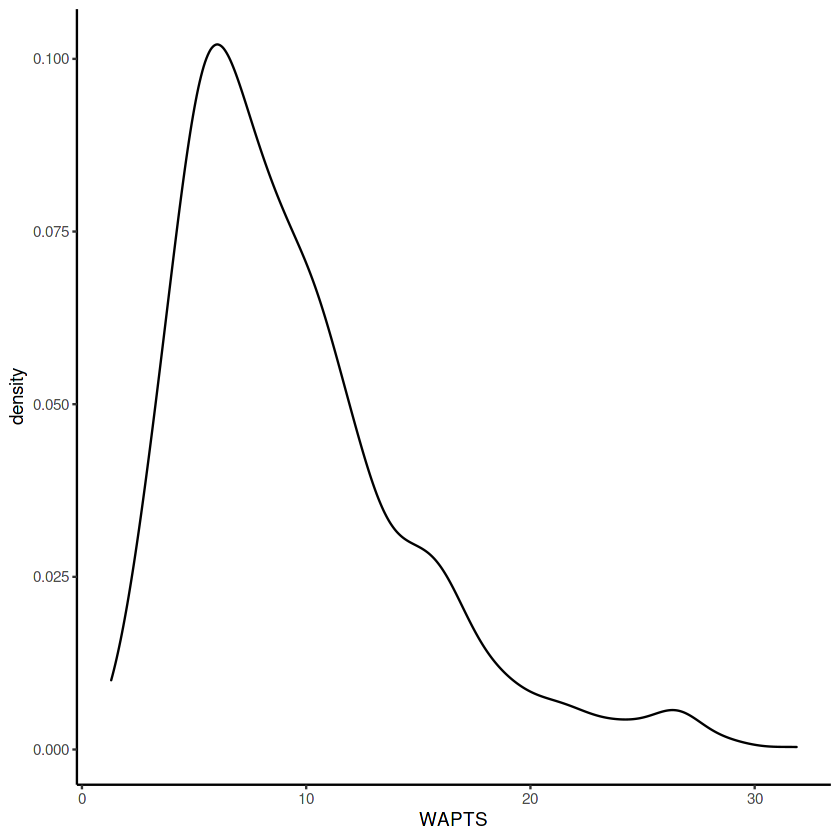

In [47]:
# univariate density plots
ggplot(sigPlayers, aes(x=WAPTS))+
    geom_density()+
    theme_classic()

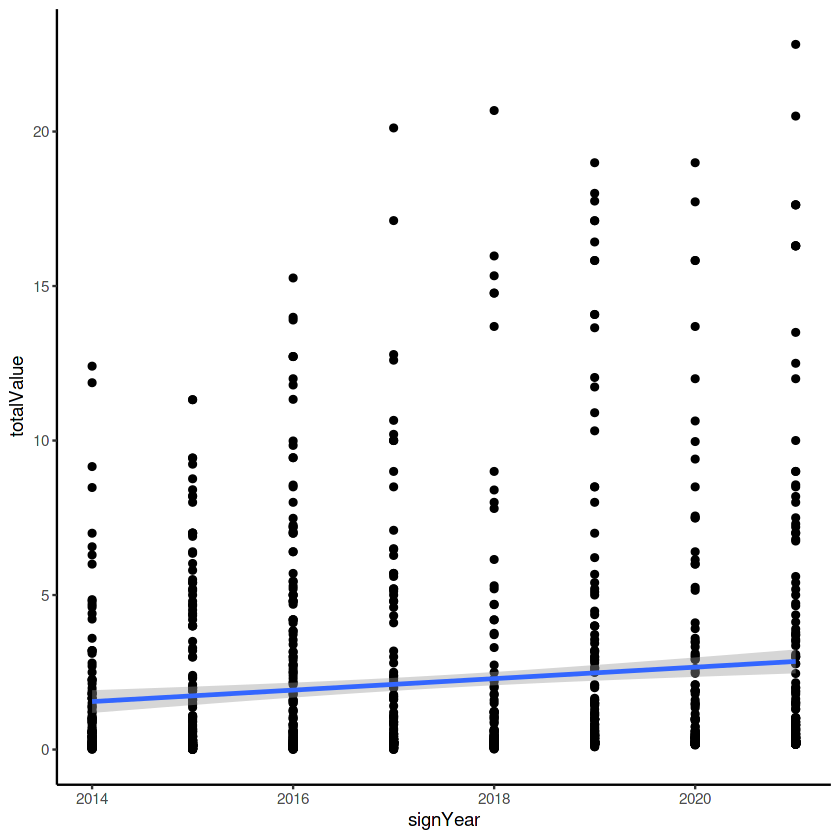

In [48]:
# scatter plots between response and predictor
ggplot(sigPlayers, aes(x=signYear, y=totalValue))+
    geom_point()+
    geom_smooth(method='lm', formula=y~x)+
    theme_classic()

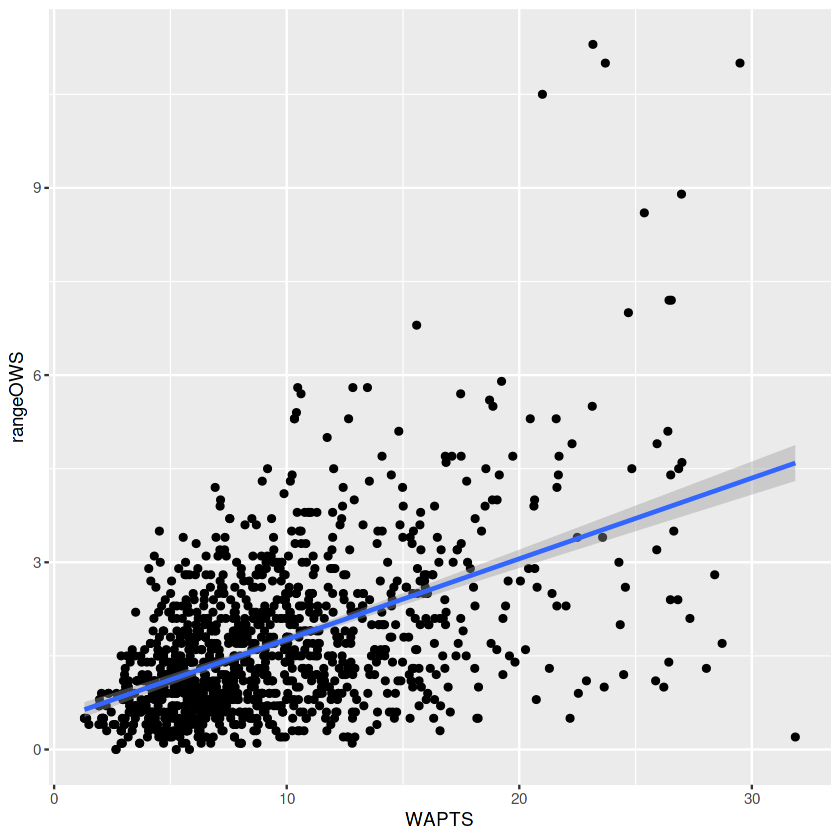

In [49]:
# scatter plot between two predictors
ggplot(sigPlayers, aes(x=WAPTS, y=rangeOWS))+
    geom_point()+
    geom_smooth(method='lm', formula=y~x)